In [1]:
import pandas as pd
import seaborn as sns
import scipy
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import pybel

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Lipinski import NumHDonors, NumHAcceptors, NumAromaticRings
import rdkit.Chem as Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

import sys
sys.path.append('../')
from utils.utils import *

%matplotlib inline

# Notebook with experiments on aromatic rings

In this notebook we show an analysis of molecules returned by the Mol-CycleGAN, for the following datasets:

1. Dataset A - molecules with 2 aromatic rings
2. Dataset B - molecules with 1 or 3 aromatic rings

**Before running this notebook, one should:**

1. Prepare train and test datasets, with *mol-cycle-gan/data/input_data/aromatic_rings/datasets_generator_aromatic_rings.ipynb* notebook.

2. Train Mol-CycleGAN and generate G(A) and F(B) datasets, with *mol-cycle-gan/scripts/run_aromatic_rings_training.sh* script.

3. Get SMILES representation of generated molecules, with *mol-cycle-gan/scripts/run_aromatic_rings_decoding.sh* script.

## Read datasets
1. smiles_A - train_A molecules 
2. smiles_B - train_B molecules 
3. smiles_A_to_B - G(test_A) molecules returned by the Mol-CycleGAN 
4. smiles_B_to_A - F(test_B) molecules returned by the Mol-CycleGAN 

In [2]:
smiles_A = pd.read_csv('../data/input_data/aromatic_rings/X_JTVAE_zinc_test_A.csv')['smiles'].values
smiles_B = pd.read_csv('../data/input_data/aromatic_rings/X_JTVAE_zinc_test_B.csv')['smiles'].values

In [3]:
smiles_A_to_B = pd.read_csv('../data/results/aromatic_rings/smiles_list_A_to_B.csv')['SMILES'].values
smiles_B_to_A = pd.read_csv('../data/results/aromatic_rings/smiles_list_B_to_A.csv')['SMILES'].values

## Plot aromatic rings distribution in A and G(A) datasets

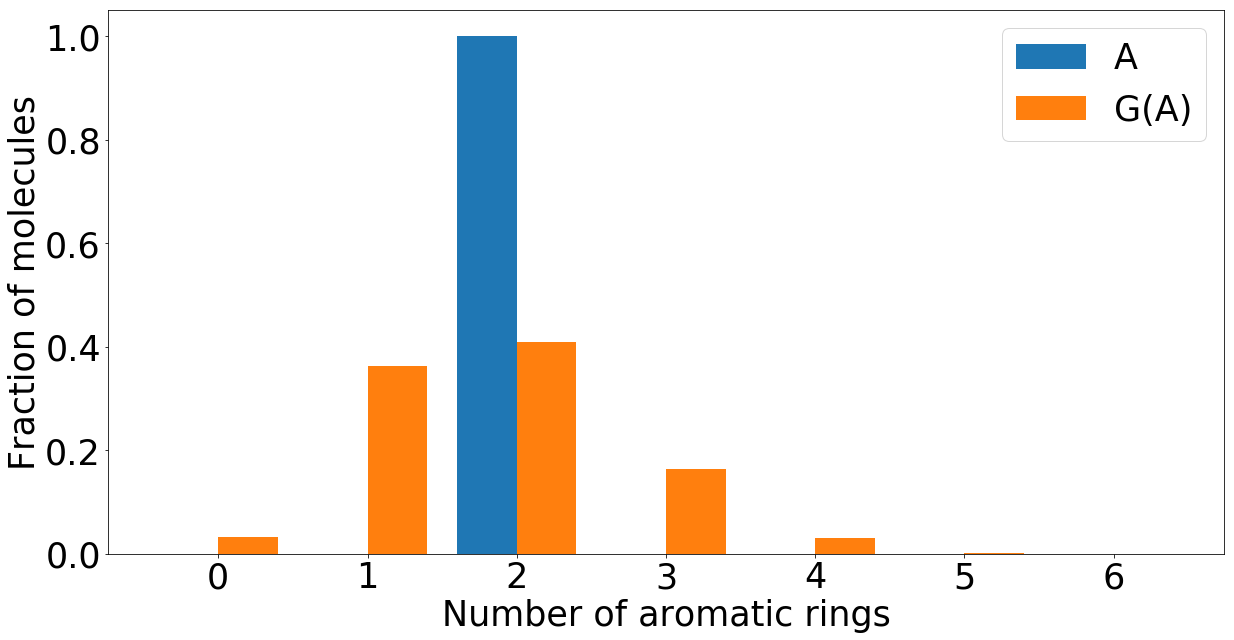

In [4]:
smiles_AR_A = get_smiles_number_of_aromatic_rings(smiles_A, delete_nans=True)
smiles_AR_A_counts = np.bincount(smiles_AR_A) / float(len(smiles_AR_A))

smiles_AR_A_to_B = get_smiles_number_of_aromatic_rings(smiles_A_to_B, delete_nans=True)
smiles_AR_A_to_B_counts = np.bincount(smiles_AR_A_to_B) / float(len(smiles_AR_A_to_B))

reps = np.array([a != b for a, b in list(zip(smiles_A, smiles_A_to_B))])
smiles_A_to_B_noreps = smiles_A_to_B[reps]
smiles_AR_A_to_B_noreps = get_smiles_number_of_aromatic_rings(smiles_A_to_B_noreps, delete_nans=True)

smiles_AR_A_to_B_counts_noreps = np.bincount(smiles_AR_A_to_B_noreps) / float(len(smiles_AR_A_to_B_noreps))

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 35})

ax = plt.subplot(111)
ax.bar(np.arange(7)-0.2, np.concatenate([smiles_AR_A_counts, np.repeat(0., 4)]), width=0.4, label='A')
ax.bar(np.arange(7)+0.2, smiles_AR_A_to_B_counts_noreps, width=0.4, label='G(A)')

plt.ylim((0, 1.05))

plt.ylabel('Fraction of molecules')
plt.xlabel('Number of aromatic rings')

plt.legend()

## Plot aromatic rings distribution in B and F(B) datasets

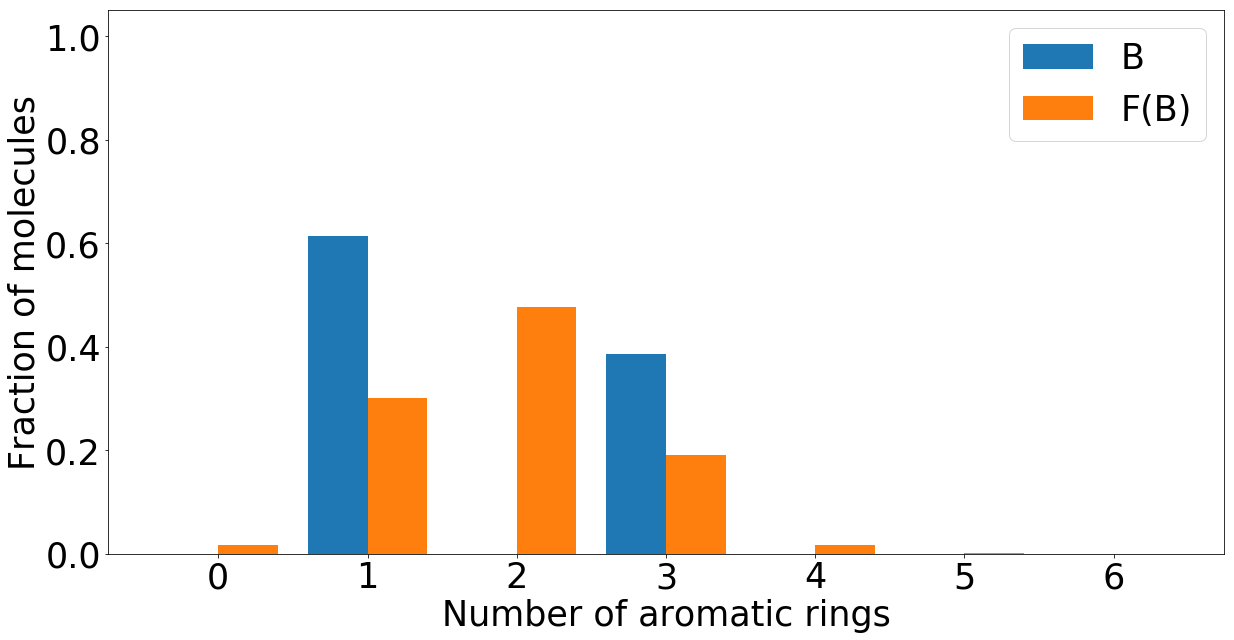

In [5]:
smiles_AR_B = get_smiles_number_of_aromatic_rings(smiles_B, delete_nans=True)
smiles_AR_B_counts = np.bincount(smiles_AR_B) / float(len(smiles_AR_B))

smiles_AR_B_to_A = get_smiles_number_of_aromatic_rings(smiles_B_to_A, delete_nans=True)
smiles_AR_B_to_A_counts = np.bincount(smiles_AR_B_to_A) / float(len(smiles_AR_B_to_A))

reps = np.array([a != b for a, b in list(zip(smiles_B, smiles_B_to_A))])
smiles_B_to_A_noreps = smiles_B_to_A[reps]

smiles_AR_B_to_A_noreps = get_smiles_number_of_aromatic_rings(smiles_B_to_A_noreps, delete_nans=True)
smiles_AR_B_to_A_counts_noreps = np.bincount(smiles_AR_B_to_A_noreps) / float(len(smiles_AR_B_to_A_noreps))


plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 35})

ax = plt.subplot(111)
ax.bar(np.arange(7)-0.2, np.concatenate([smiles_AR_B_counts, np.repeat(0., 3)]), width=0.4, label='B')
ax.bar(np.arange(7)+0.2, np.concatenate([smiles_AR_B_to_A_counts_noreps, [0.]]), width=0.4, label='F(B)')

plt.ylim((0, 1.05))

plt.ylabel('Fraction of molecules')
plt.xlabel('Number of aromatic rings')

plt.legend()

## Table with datasets statistics

In [6]:
results_df = pd.DataFrame({
                ' ': ['Success rate', 'Diversity', 'Non-identity'],
                'A -> G(A)': [np.sum(np.array(smiles_AR_A_to_B) != 2.) / float(len(smiles_A_to_B)), len(set(smiles_A_to_B)) / float(len(smiles_A_to_B)), 1. - len(set(smiles_A_to_B) & set(smiles_A)) / float(len(set(smiles_A_to_B)))],
                'B -> F(B)': [np.sum(np.array(smiles_AR_B_to_A) == 2.) / float(len(smiles_B_to_A)), len(set(smiles_B_to_A)) / float(len(smiles_B_to_A)), 1. - len(set(smiles_B_to_A) & set(smiles_B)) / float(len(set(smiles_B_to_A)))]
            }).set_index(' ')
results_df

,A -> G(A),B -> F(B)
,,
Success rate,0.534193,0.421596
Diversity,0.995719,0.995370
Non-identity,0.908169,0.889889


## Plot distribution of tanimoto similarity between A and G(A) datasets

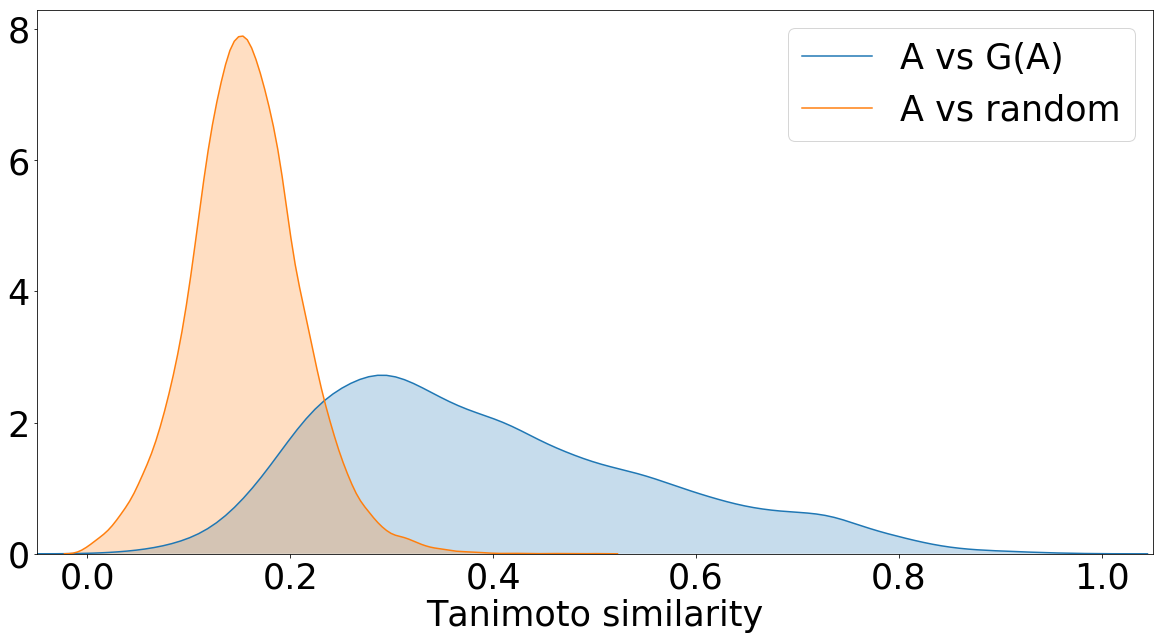

In [7]:
distances_A_to_B = create_tanimoto_column(smiles_A, smiles_A_to_B)

zinc_smiles = pd.read_csv('../data/input_data/250k_rndm_zinc_drugs_clean_3_canonized.csv')[['smiles']].values.reshape(-1,)
indices = np.random.permutation(zinc_smiles.shape[0])
indices = indices[0:smiles_A.shape[0]]
distances_A_to_B_random = create_tanimoto_column(smiles_A, zinc_smiles[indices])
    

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 35})
sns.kdeplot(distances_A_to_B[distances_A_to_B != 1], shade=True, label='A vs G(A)')
sns.kdeplot(distances_A_to_B_random, shade=True, label='A vs random')

plt.xlabel('Tanimoto similarity')
plt.xlim((-0.05, 1.05))
plt.legend()

## Plot distribution of tanimoto similarity between B and F(B) datasets

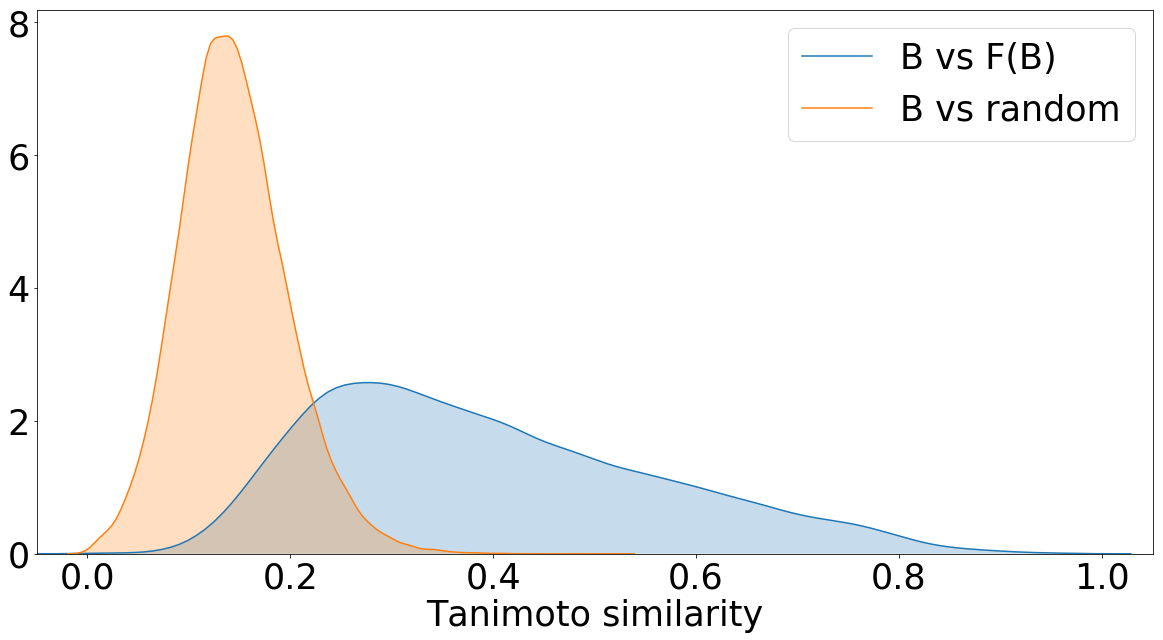

In [8]:
distances_B_to_A = create_tanimoto_column(smiles_B, smiles_B_to_A)

zinc_smiles = pd.read_csv('../data/input_data/250k_rndm_zinc_drugs_clean_3_canonized.csv')[['smiles']].values.reshape(-1,)
indices = np.random.permutation(zinc_smiles.shape[0])
indices = indices[0:smiles_B.shape[0]]
distances_B_to_A_random = create_tanimoto_column(smiles_B, zinc_smiles[indices])

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 35})
sns.kdeplot(distances_B_to_A[distances_B_to_A != 1], shade=True, label='B vs F(B)')
sns.kdeplot(distances_B_to_A_random, shade=True, label='B vs random')

plt.xlabel('Tanimoto similarity')
plt.xlim((-0.05, 1.05))
plt.legend()

## Plot distribution of tanimoto similarity

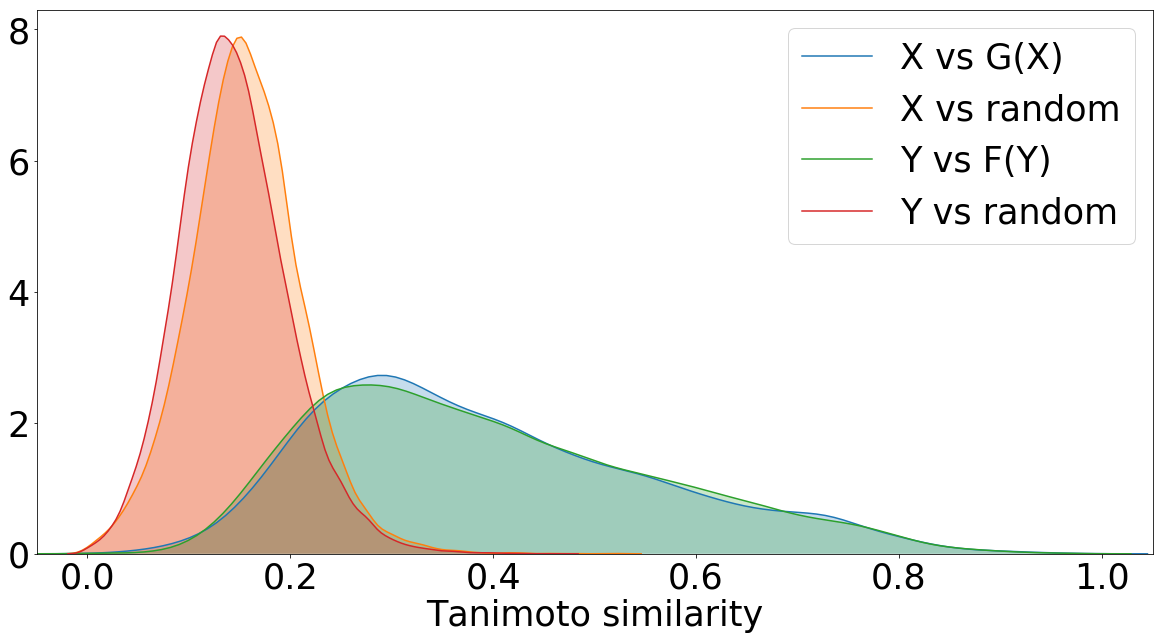

In [9]:
distances_A_to_B = create_tanimoto_column(smiles_A, smiles_A_to_B)
distances_B_to_A = create_tanimoto_column(smiles_B, smiles_B_to_A)

zinc_smiles = pd.read_csv('../data/input_data/250k_rndm_zinc_drugs_clean_3_canonized.csv')[['smiles']].values.reshape(-1,)

indices_A = np.random.permutation(zinc_smiles.shape[0])
indices_A = indices_A[0:smiles_A.shape[0]]
distances_A_to_B_random = create_tanimoto_column(smiles_A, zinc_smiles[indices_A])

indices_B = np.random.permutation(zinc_smiles.shape[0])
indices_B = indices_B[0:smiles_B.shape[0]]
distances_B_to_A_random = create_tanimoto_column(smiles_B, zinc_smiles[indices_B])

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 35})

sns.kdeplot(distances_A_to_B[distances_A_to_B != 1], shade=True, label='X vs G(X)')
sns.kdeplot(distances_A_to_B_random, shade=True, label='X vs random')

sns.kdeplot(distances_B_to_A[distances_B_to_A != 1], shade=True, label='Y vs F(Y)')
sns.kdeplot(distances_B_to_A_random, shade=True, label='Y vs random')

plt.xlabel('Tanimoto similarity')
plt.xlim((-0.05, 1.05))
plt.legend()

## Plot most similar molecules from A and G(A) datasets

In [10]:
df_best_scores = crate_df_with_best_scores(smiles_A, smiles_A_to_B)

In [11]:
best_mols = df_best_scores[df_best_scores['same_aromatic_number'] == False]
best_mols['tanimoto'] = create_tanimoto_column(best_mols['A'].values, best_mols['B'].values)
best_mols.sort_values('tanimoto', ascending=False, inplace=True)
best_mols = best_mols.iloc[0:10]
best_mols['mol_A'] = best_mols['A'].apply(smiles_to_mol)
best_mols['mol_B'] = best_mols['B'].apply(smiles_to_mol)
best_mols['tanimoto'] = best_mols['tanimoto'].apply(lambda x: np.round(x, 3))

/opt/conda/envs/molcyclegan/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/molcyclegan/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


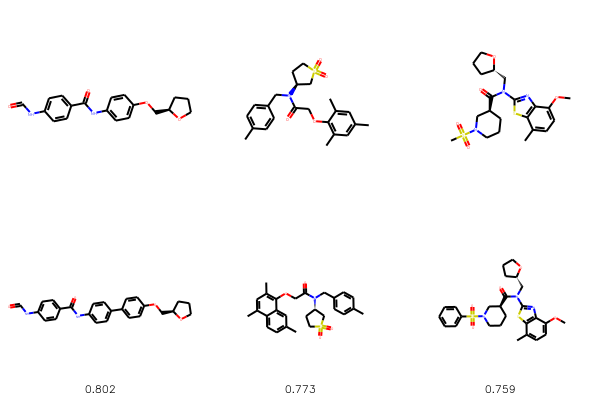

In [12]:
img_1 = PandasTools.FrameToGridImage(best_mols.iloc[0:3], column='mol_A', molsPerRow=3)
img_2 = PandasTools.FrameToGridImage(best_mols.iloc[0:3], column='mol_B', legendsCol='tanimoto', molsPerRow=3)

new_im = Image.new('RGB', (600, 400))

new_im.paste(img_1, (0, 0))
new_im.paste(img_2, (0, 200))

display(new_im)

## Plot most similar molecules from B and F(B) datasets

In [13]:
df_best_scores = crate_df_with_best_scores(smiles_B, smiles_B_to_A)

In [14]:
best_mols = df_best_scores[df_best_scores['same_aromatic_number'] == False]
best_mols['tanimoto'] = create_tanimoto_column(best_mols['A'].values, best_mols['B'].values)
best_mols.sort_values('tanimoto', ascending=False, inplace=True)
best_mols = best_mols.iloc[0:10]
best_mols['mol_A'] = best_mols['A'].apply(smiles_to_mol)
best_mols['mol_B'] = best_mols['B'].apply(smiles_to_mol)
best_mols['tanimoto'] = best_mols['tanimoto'].apply(lambda x: np.round(x, 3))

/opt/conda/envs/molcyclegan/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/molcyclegan/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


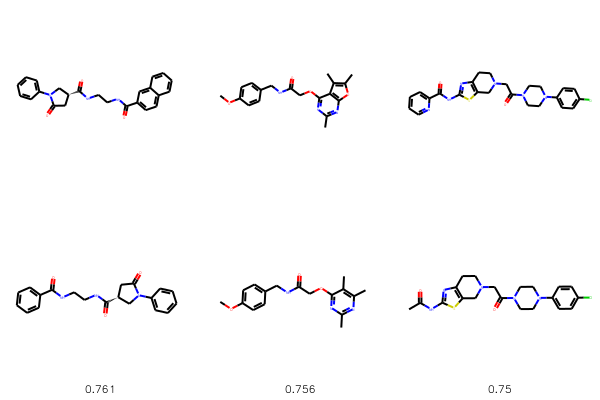

In [15]:
img_1 = PandasTools.FrameToGridImage(best_mols.iloc[0:3], column='mol_A', molsPerRow=3)
img_2 = PandasTools.FrameToGridImage(best_mols.iloc[0:3], column='mol_B', legendsCol='tanimoto', molsPerRow=3)

new_im = Image.new('RGB', (600, 400))

new_im.paste(img_1, (0, 0))
new_im.paste(img_2, (0, 200))

display(new_im)